# Adam Thomson - PHY 574 - Week 2

## Quantum Error Correction via Repetition Code (cont.)

### Lookup Table Decoding
Continue following the qiskit notebook for error correction repetition code https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-hardware/error-correction-repetition-code.ipynb
- Copy the code from "Lookup table decoding" section
  - Add comments and change the inputs, describe results
- Summarize the "Graph theoretic decoding" section

In [31]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import defaultdict
from math import gcd
from numpy.random import randint
from IPython.display import Math, HTML
from qiskit import QuantumCircuit as QCir, \
                   QuantumRegister as QReg, \
                   ClassicalRegister as CReg, \
                   transpile
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.noise.errors import pauli_error, depolarizing_error

# Initialize local simulator
sampler = AerSimulator()

# Declare shortcut function
def dm(x):
    return display(Math(x))

In [4]:
# Import NCCR_SPIN/topological codes

# Note: I needed to modify the topological_codes/fitter.py file to update the Aer import path to be compatible with latest qiskit

from topological_codes import RepetitionCode
from topological_codes import lookuptable_decoding
from topological_codes import GraphDecoder

In [50]:
# Copy helper functions from week 1
def get_noise(p_meas, p_gate):
    """
    Generate and return a noise model based on input probabilities
    
    Parameters:
    p_meas (float): probability of corruption during the measurement process
    p_gate (float): probability that a logic gate will put a qubit into a random state

    Returns:
    qiskit_aer.noise.NoiseModel
    """
    # Use input p_meas to randomly determine if an X gate or I gate should be applied
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])

    # Use the qiskit included library to generate the 1-qubit and 2-qubit error gates
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()                                     # Initiliaze a qiskit NoiseModel
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"])    # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"])   # two qubit gate error is applied to cx gates
        
    return noise_model

def get_raw_results(code, noise_model=None, num_shots=1024):
    """
    Applies a NoiseModel to generated repetition circuits 

    Parameters:
        code (RepetitionCode)    : generated by topological_codes library based on encoding qubits and syndrome rounds
        noise_model (NoiseModel) : will be used as noise model for simulation purposes

    Returns:
        dict: A dictionary containing simulation result counts
    """
    circuits = code.get_circuit_list()   # Fetch the circuits generated by RepetitionCode
    raw_results = {}                     # Initialize the return object
    for log in range(2):                 # Perform loop on both circuits in the RepetitionCode
        # Run the circuit with noisy simulation
        job = sampler.run(circuits[log], noise_model=noise_model, shots=num_shots)
        # Add results to return object
        raw_results[str(log)] = job.result().get_counts(str(log))

    return raw_results

## Lookup table decoding

Picking up from where we left off, let's now examine what happens when we introduce some noise to the simulation model.

In [25]:
# copy qiskit code
code = RepetitionCode(3, 1)         # Generate the quantum circuits
noise_model = get_noise(0.05, 0.05) # Create model with p_meas = p_gate = 5%

# Run the repetition circuits using noise model
raw_results = get_raw_results(code, noise_model)
for log in raw_results:
    print(f"Logical {log}: {raw_results[log]}\n")

Logical 0: {'010 11': 2, '011 10': 1, '101 00': 2, '101 10': 1, '011 00': 2, '100 00': 45, '001 00': 49, '000 00': 669, '000 10': 69, '001 10': 3, '010 00': 48, '100 01': 6, '001 01': 11, '010 01': 27, '000 11': 5, '011 01': 1, '010 10': 4, '110 00': 4, '000 01': 66, '100 10': 9}

Logical 1: {'010 10': 2, '001 10': 2, '010 00': 4, '011 11': 2, '100 11': 2, '110 10': 2, '100 01': 1, '010 01': 2, '011 10': 15, '101 10': 5, '101 01': 22, '111 00': 621, '101 11': 16, '111 01': 62, '101 00': 37, '110 01': 21, '001 00': 7, '110 11': 6, '100 00': 4, '111 11': 6, '110 00': 64, '111 10': 73, '011 00': 42, '011 01': 6}



In [32]:
# define helper function to examine results
def parse_repetition_results(rep_results):
    """
    Transforms the result of repetition code raw results into the measurement counts for plotting
    """
    # Initialize plot dicts to 0 count for each measurement
    rep_counts0 = defaultdict(int)
    rep_counts1 = defaultdict(int)
    
    # Parse repetition results
    for result, count in rep_results['0'].items():
        rep_counts0[result.split(' ')[0]] += count
    for result, count in rep_results['1'].items():
        rep_counts1[result.split(' ')[0]] += count

    # Plot the counts
    return (rep_counts0, rep_counts1)

In [33]:
rep0, rep1 = parse_repetition_results(raw_results)

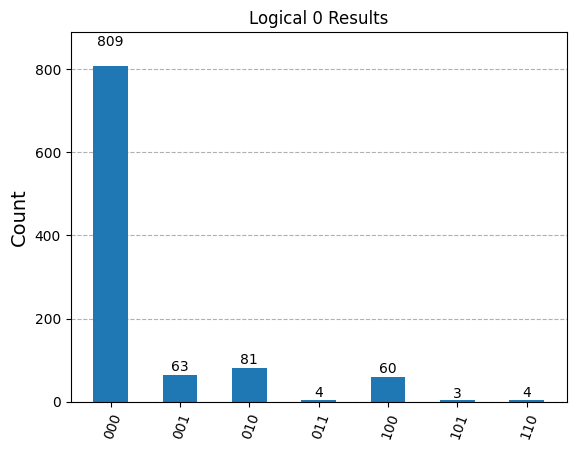

In [34]:
plot_histogram(rep0, title="Logical 0 Results")

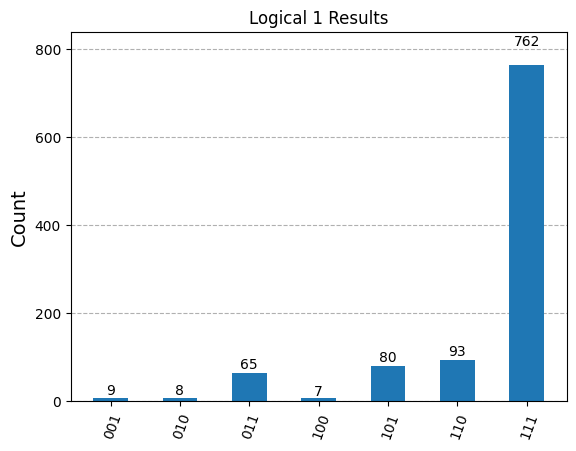

In [35]:
plot_histogram(rep1, title="Logical 1 Results")

We see now that our encoded results are not always `|000>` and `|111>`. Since p_meas and p_gate are fairly low, we see that the results with the highest count are still 000 for logical 0, and 111 for logical 1 - and we find that the decoded result will almost always match the expected logical value.

Let's examine what happens when each variable is modified:

In [43]:
# modify encoding qubits
code_5q = RepetitionCode(5, 1)  # Use 5 qubits instead of 3

# Run the noisy simulation and plot results
raw_results_5q = get_raw_results(code_5q, noise_model)
rep0_5q, rep1_5q = parse_repetition_results(raw_results_5q)
for log in raw_results_5q:
    print(f'Logical {log}: {raw_results_5q[log]}\n')

Logical 0: {'01100 0100': 1, '10100 0010': 1, '00101 0001': 1, '00110 0011': 1, '01010 0001': 1, '11000 0100': 1, '01000 0110': 1, '00110 1000': 1, '00001 0011': 1, '00100 0110': 2, '01110 0100': 1, '00101 1000': 1, '10001 0001': 1, '10000 0010': 3, '11010 0000': 1, '01000 1000': 6, '10000 1000': 5, '00001 0100': 3, '00001 0110': 1, '00100 0001': 7, '01010 0101': 1, '01100 0010': 1, '00010 1000': 6, '00100 0100': 5, '00000 0100': 44, '00010 0001': 17, '00100 0011': 2, '00010 0100': 5, '00100 0000': 36, '01000 0101': 2, '01001 1000': 1, '00000 0010': 47, '11011 1000': 1, '00001 0010': 3, '00000 0000': 434, '10100 0000': 5, '01001 0000': 3, '00010 0101': 2, '10001 0010': 1, '01000 0000': 35, '01000 1100': 1, '01100 0000': 7, '01000 0100': 20, '00010 0110': 1, '00010 0000': 38, '00000 0011': 3, '10000 0101': 1, '00111 1001': 1, '10010 0010': 1, '00000 1000': 44, '10000 0001': 3, '01001 0010': 1, '00000 0110': 2, '00001 0001': 7, '01101 0000': 1, '00000 0101': 4, '10000 0100': 2, '10110 00

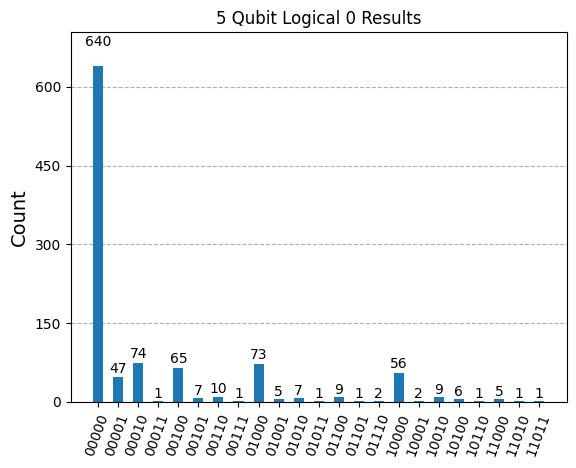

In [44]:
plot_histogram(rep0_5q, title="5 Qubit Logical 0 Results")

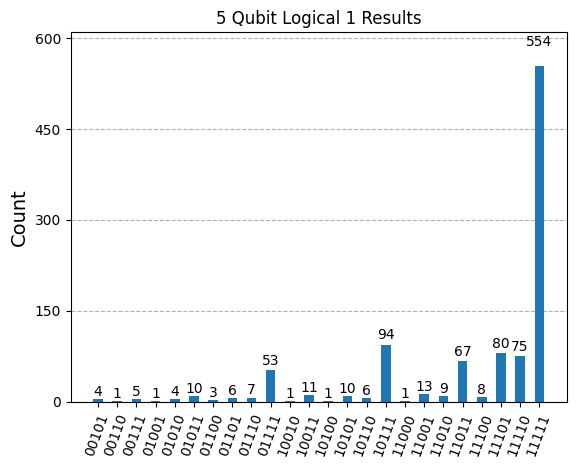

In [45]:
plot_histogram(rep1_5q, title="5 Qubit Logical 1 Results")

With more qubits we find what we expect - with more activity in the circuit there is higher overall error, measurements of `00000` and `11111` are less likely, but the decoded result has a lower probability of being the incorrect logical value.

In [46]:
# modify repetition count
code_3t = RepetitionCode(3, 3)   # Use T=3 instead of T=1

# Run the noisy simulation and plot results
raw_results_3t = get_raw_results(code_3t, noise_model)
rep0_3t, rep1_3t = parse_repetition_results(raw_results_3t)
for log in raw_results_3t:
    print(f'Logical {log}: {raw_results_3t[log]}\n')

Logical 0: {'111 10 00 00': 1, '010 11 10 00': 1, '000 01 00 10': 1, '010 01 01 01': 4, '010 11 00 00': 17, '010 11 00 01': 2, '010 00 00 00': 33, '010 01 11 00': 2, '010 11 10 11': 1, '100 01 11 00': 4, '000 11 01 00': 4, '000 00 10 01': 1, '100 00 10 01': 1, '010 00 11 10': 2, '110 10 01 00': 2, '100 11 01 01': 1, '110 01 00 01': 2, '000 11 01 01': 5, '001 01 11 01': 1, '010 01 01 00': 4, '000 00 10 00': 6, '101 01 00 00': 1, '100 10 00 10': 4, '101 00 11 00': 1, '001 11 10 10': 3, '011 11 00 00': 3, '011 11 10 10': 1, '100 01 01 00': 1, '001 01 01 00': 7, '000 01 01 01': 35, '000 00 00 01': 4, '100 10 10 10': 1, '100 00 00 00': 25, '001 11 11 00': 2, '010 11 00 11': 1, '000 10 10 00': 44, '111 10 01 11': 1, '000 01 10 01': 1, '101 10 10 10': 1, '001 01 00 00': 6, '100 10 10 00': 3, '010 00 01 01': 3, '010 00 00 01': 1, '000 10 10 10': 47, '000 10 00 00': 30, '100 01 00 00': 5, '010 00 01 10': 1, '110 01 00 00': 1, '010 01 10 01': 16, '011 11 10 00': 1, '010 11 01 00': 1, '001 00 01 

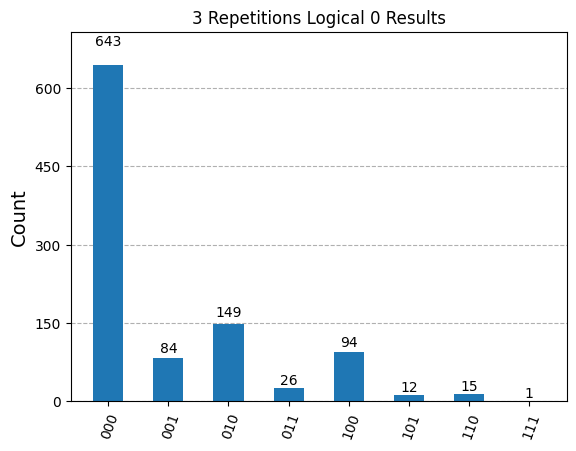

In [41]:
plot_histogram(rep0_3t, title="3 Repetitions Logical 0 Results")

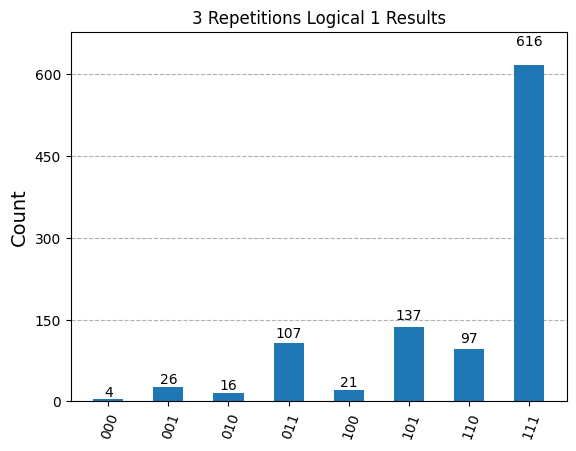

In [42]:
plot_histogram(rep1_3t, title="3 Repetitions Logical 1 Results")

By extending the length of the circuit with redundant repetition rounds, we've introduced more error into the system - this has increased the probability of decoding to the incorrect logical value.

In [47]:
# Modify the error rate
code_10p = RepetitionCode(3, 1)
noise_model_10p = get_noise(0.1, 0.1) # Build a noise model with p_meas = p_gate = 10%

# Run the noisy simulation and plot results
raw_results_10p = get_raw_results(code_10p, noise_model_10p)
rep0_10p, rep1_10p = parse_repetition_results(raw_results_10p)
for log in raw_results_10p:
    print(f'Logical {log}: {raw_results_10p[log]}\n')

Logical 0: {'001 11': 1, '010 11': 7, '011 01': 9, '100 11': 8, '001 01': 12, '010 01': 41, '100 01': 18, '110 10': 4, '100 00': 63, '001 00': 85, '010 10': 8, '000 10': 90, '010 00': 75, '011 00': 10, '001 10': 18, '000 01': 90, '100 10': 16, '111 00': 5, '101 01': 1, '101 00': 11, '000 11': 14, '110 00': 13, '110 11': 2, '111 11': 1, '000 00': 407, '110 01': 8, '011 10': 4, '101 10': 1, '111 10': 1, '011 11': 1}

Logical 1: {'010 11': 1, '001 00': 8, '101 01': 33, '111 00': 361, '100 10': 4, '100 00': 8, '110 00': 67, '110 11': 8, '111 11': 24, '011 10': 36, '011 00': 53, '010 00': 7, '001 10': 7, '111 10': 87, '101 11': 24, '101 00': 69, '111 01': 89, '010 01': 7, '100 01': 10, '001 01': 8, '110 10': 22, '011 01': 9, '110 01': 34, '000 00': 2, '101 10': 19, '001 11': 9, '100 11': 4, '011 11': 5, '010 10': 7, '000 10': 2}



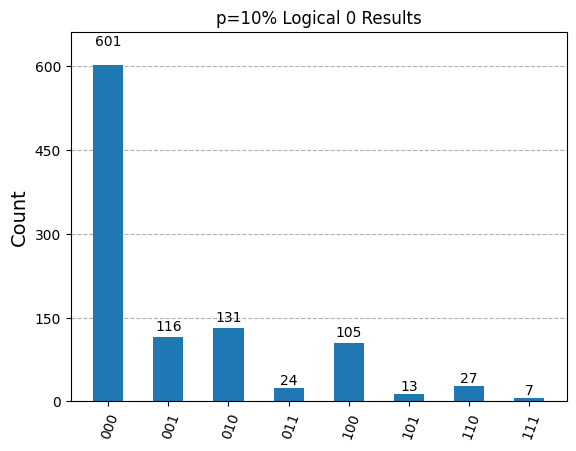

In [48]:
plot_histogram(rep0_10p, title="p=0.1 Logical 0 Results")

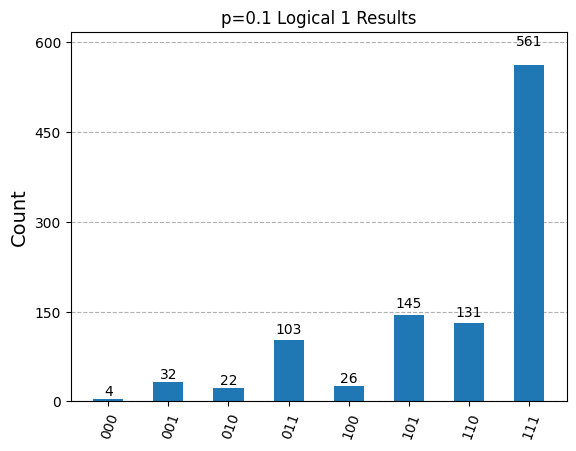

In [49]:
plot_histogram(rep1_10p, title="p=0.1 Logical 1 Results")

As expected, by increasing the probability of error we have increased the probability of decoding the measurement to the incorrect logical value.

Determining `P`, the probability of incorrect decoding, for a given circuit can be accomplished by comparinig two sets of results. First, we need the results to be decoded and for which we're calculating `P`. Secondly, we need a lookup table with a large number of samples to ensure good statistics.

In [52]:
# Use 10K shots to generate the lookup results
table_results = get_raw_results(code, noise_model, 10000)
table_results_5q = get_raw_results(code_5q, noise_model, 10000)
table_results_3t = get_raw_results(code_3t, noise_model, 10000)
table_results_10p = get_raw_results(code_10p, noise_model_10p, 10000)

We now use the included `lookuptable_decoding` function to comparing decoding results and calculate `P`.

In [62]:
# Calculate qiskit example P
p = lookuptable_decoding(raw_results, table_results)
dm(r"P = \{\text{p}\}".replace("{p}", str(p)))

<IPython.core.display.Math object>

In [61]:
# Calculate P for my custom circuits
p_5q = lookuptable_decoding(raw_results_5q, table_results_5q)
dm(r"P_{5q} = \{\text{{p_5q}}\}".replace("{p_5q}", str(p_5q)))
p_3t = lookuptable_decoding(raw_results_3t, table_results_3t)
dm(r"P_{3t} = \{\text{{p_3t}}\}".replace("{p_3t}", str(p_3t)))
p_10p = lookuptable_decoding(raw_results_10p, table_results_10p)
dm(r"P_{10p} = \{\text{{p_10p}}\}".replace("{p_10p}", str(p_10p)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

These all align with our previously stated expectations:
- By increasing the number of qubits, we decrease P
- By increasing repetition rounds, we incroduce more error and increase P
- With a higher probability of incidivual errors, we see an increase in overall P as well

#### Graph theoretic decoding

This section of the qiskit notebook describes how we can use the `process_results` method from the `topological_codes` library to transform the raw results into a form that is more easily applicable to the following use case. Instead of inspecting the state of each syndrome during each round, we can instead compare the syndrome results to each other across rounds. This allows us to construct a graph of the syndrome space, with each node representing an output string bit and each edge representing the pair of qubits effected by an error captured in that bit. This enables us to apply Graph Theory techniques such as minimum weight perfect matching in order to better analyze our error space.